In [9]:
import pygmsh as pg
import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment, plot_boundary_mesh
from util.random import smooth_random_loop_fourier_coef, fourierGP_2D_lerp
from util.logger import EventTracker
from util.plot_tools import remove_axes
from dataclasses import dataclass
import meshio
import gmsh
from hmm.stokes_deep_fenics import DeepMicroSolverFenics, get_net
from typing import List, Tuple, Callable, Dict, Optional, Union

np.random.seed(0)
net_dir = "/mnt/data0/emastr/article_training_nodecay/"
MESH_PATH = "/home/emastr/deep-micro-slip-model/data/mesh/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
simulation_dir = "/home/emastr/deep-micro-slip-model/data/stokes_fenics/"

### Setup 

Create geometry with random rough boundary. 

In [10]:
def list_sum(lists):
    return [item for sublist in lists for item in sublist]

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

class CircleDomain(dl.SubDomain):
    def __init__(self, x, y, r, tol, bdry=True):
        self.x = x
        self.y = y
        self.r = r
        self.tol = tol
        self.bdry = bdry
        super(CircleDomain, self).__init__()
        
    def inside(self, x, on_boundary):
        if self.bdry:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol) and on_boundary)
        else:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol))
        

class UnionDomain(dl.SubDomain):
    def __init__(self, domains):
        self.domains = domains
        super(UnionDomain, self).__init__()
    
    def inside(self, x, on_boundary):
        return bool(any([domain.inside(x, on_boundary) for domain in self.domains]))


class Insets(dl.SubDomain):
    def __init__(self, R, r):
        self.R = R
        self.r = r
        self.TOL = 1e-3
        super(Insets, self).__init__()
        
    def inside(self, x, on_boundary):
        dist = x[0]**2 + x[1]**2
        return bool((dist < self.R**2 - self.TOL) and (dist > self.r**2 + self.TOL) and on_boundary)
    

def circle(x, y, r, N):
    return ms.Circle(dl.Point(x, y), r) #N


@dataclass
class RoughKullager:
    # Main parameters
    R: float
    r: float
    N_blobs: int
    
    # Child parameters
    r_blobs: float
    x_blobs: List[dl.Point]
    bbox: List[List[float]]

    # File names
    name: str = ""
    rough_name: str = ""
    
    @staticmethod
    def from_main_pars(R, r, N_blobs):
        pos_blob = (R + r) / 2
        r_blob = (R - r) / 5
        thetas = np.linspace(0, 2*np.pi, N_blobs+1)[:-1]
        radii = np.cos(N_blobs/2 * thetas) * ((R - r)*(0.3) - r_blob) + pos_blob
        x_blobs = [dl.Point(rad*np.cos(theta), rad*np.sin(theta)) for rad, theta in zip(radii, thetas)]
        return RoughKullager(R, r, N_blobs, r_blob, x_blobs, [[-R, R], [-R, R]])
    
    
    def get_micro_points(self, N_per_blob):
        pts = []
        for n in range(self.N_blobs):
            t = np.linspace(0, 2*np.pi, N_per_blob+1)[:-1]
            x = self.x_blobs[n].x()
            y = self.x_blobs[n].y()
            pts.append(np.hstack([x + self.r_blobs * np.cos(t)[:, None], y + self.r_blobs * np.sin(t)[:, None]]))
        return np.vstack(pts)
    
    
    def create_domains(self, TOL=0.03):
        outer = CircleDomain(0, 0, self.R, TOL, False)
        inner = CircleDomain(0, 0, self.r, TOL, False)
        inclusions = [CircleDomain(self.x_blobs[i].x(), self.x_blobs[i].y(), self.r_blobs, TOL, False) for i in range(self.N_blobs)]
        
        outer_bdry = CircleDomain(0, 0, self.R, TOL, True)
        inner_bdry = CircleDomain(0, 0, self.r, TOL, True)
        inclusion_bdry = Insets(self.R, self.r)
        
        return outer, inner, inclusions, outer_bdry, inner_bdry, inclusion_bdry
    
    
    def save_geometry(self, file_name, resmax, resmin):
        
        # Create the geometry
        with pg.geo.Geometry() as geom:
            
            insets = []
            for roughness in self.roughnesses:
                points = []
                for k in range(roughness.shape[0]):
                    points.append(geom.add_point([roughness[k, 0], roughness[k, 1]]))#, self.lcar))
                s1 = geom.add_bspline(points[0:self.N_//2+1])
                s2 = geom.add_bspline(points[self.N_//2:] + [points[0]])
                l  = geom.add_curve_loop([s1, s2])
                insets.append(l)
                
                
            outer = geom.add_circle([0, 0], self.R)#, mesh_size=resmin)
            inner = geom.add_circle([0, 0], self.r)#, mesh_size=resmin)    
            surf = geom.add_plane_surface(outer.curve_loop, holes=[inner.curve_loop] + insets)
            geom.add_physical(surf, label='Inside')
            geom.add_physical(outer.curve_loop.curves + inner.curve_loop.curves + list_sum([inset.curves for inset in insets]), label='Dirichlet')
            #geom.add_physical(list_sum([inc.curve_loop.curves for inc in inclusions[1:]]), label='Roughness')
            
            #res_min = 0.002
            #res_max = 0.05
            res_min = 0.003
            res_max = 0.08
            
            c = res_min
            a = np.log(res_max / res_min) / (self.R - self.r) * 2.
            geom.set_mesh_size_callback(lambda dim, tag, x, y, z, lc: \
                c * np.exp((min([((x - blob.x())**2 + (y - blob.y())**2)**0.5 for blob in self.x_blobs]) - self.r_blobs)*a))
            
            mesh = geom.generate_mesh(dim=2)
            gmsh.write(f'{MESH_PATH}temp.msh')        
            
            mesh = meshio.read(f'{MESH_PATH}temp.msh')
            
            bdry = create_mesh(mesh, "line", True)
            mesh = create_mesh(mesh, "triangle", True)
            
            meshio.write(f'{MESH_PATH}{file_name}_volume_hd.xdmf', mesh)
            meshio.write(f'{MESH_PATH}{file_name}_boundary_hd.xdmf', bdry)
        self.name = file_name
        
    
    def create_roughness(self, file_name, eps=0.004, lcar=0.002):
        # Create rough inset
        roughness_field, x, y = fourierGP_2D_lerp(kmax_x=1001, kmax_y=1001, L=0.08, LAmp=0.1, eps=0.004, epsAmp=0.02, dom=self.bbox, seed=0)
        roughnesses = []
        N_ = 500
        for n in range(self.N_blobs):
            t = np.linspace(0, 2*np.pi, N_+1)[:-1]
            x = self.x_blobs[n].x()
            y = self.x_blobs[n].y()
            
            cos_t = np.cos(t)
            sin_t = np.sin(t)
            x_t = x + self.r_blobs * cos_t
            y_t = y + self.r_blobs * sin_t
            #r = self.r * 0.90# -roughness_field(x, y) #0.02*(1 + np.sin(100 * t)))#
            r = self.r_blobs - 0*roughness_field(x_t, y_t) #0.02*(1 + np.sin(100 * t)))#
            roughnesses.append(np.hstack([x + (r * cos_t)[:, None], y + (r * sin_t)[:, None]]))
        self.roughnesses = roughnesses
        self.roughness_field = roughness_field
        self.rough_name = file_name
        self.N_ = N_
        self.lcar = lcar
    
    
    def load_meshes(self):
        file = dl.XDMFFile(f'{MESH_PATH}{self.name}_volume_hd.xdmf')
        mesh = dl.Mesh()
        file.read(mesh)

        bdry_file = dl.XDMFFile(f'{MESH_PATH}{self.name}_boundary_hd.xdmf')
        bdry = dl.Mesh()
        bdry_file.read(bdry)

        
        return mesh, bdry
        
    def plot(self, ax):
        for r in self.roughnesses:
            ax.plot(r[:, 0], r[:, 1], 'k')
        ax.plot([self.R*np.cos(t) for t in np.linspace(0, 2*np.pi, 100)], [self.R*np.sin(t) for t in np.linspace(0, 2*np.pi, 100)], 'k')
        ax.plot([self.r*np.cos(t) for t in np.linspace(0, 2*np.pi, 100)], [self.r*np.sin(t) for t in np.linspace(0, 2*np.pi, 100)], 'k')
        ax.set_aspect('equal')

## Instantiate 

Instantiate geometries, build mesh. If hyperparameters change, uncomment line 7. 

In [11]:
R = 1.
r = 0.3
N_blobs = 7

data = RoughKullager.from_main_pars(R, r, N_blobs)
outer, inner, inclusions, outer_bdry, inner_bdry, inclusion_bdry = data.create_domains(TOL=0.03)
data.create_roughness('test_mesh_2', 0.004, 0.001)
data.save_geometry('test_mesh', 0.02, 0.05) #0.03



In [12]:

#### ROUGHNESS FUNCTION ####


#data.save_geometry('test_mesh', 0.02, 0.05) #0.03

mesh, bdry = data.load_meshes()

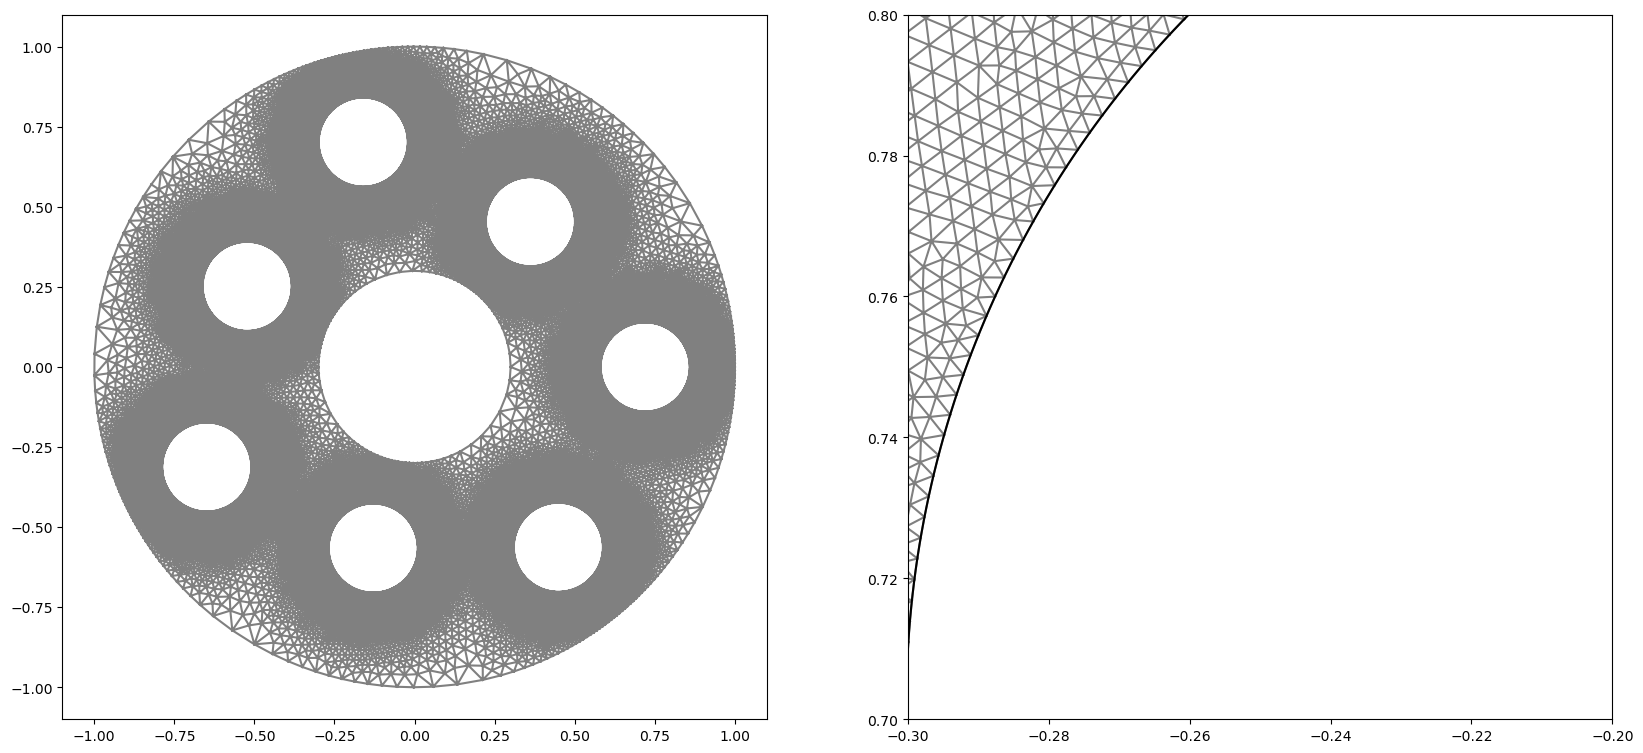

In [13]:

plt.figure(figsize=(20, 10))

plt.subplot(121)
dl.plot(mesh)

plt.subplot(122)
dl.plot(mesh)
plt.ylim([0.7, 0.8])
plt.xlim([-0.3, -0.2])

data.plot(plt.gca())

## Problem Formulation

Define function spaces, hmm problems.

In [14]:
import typing
import time
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from util.basis_scaled import FourBasis, ChebBasis, ScaleShiftedBasis
from util.plot_tools import *
from hmm.hmm import MacroProblem, MicroProblem, HMMProblem, Solver, IterativeHMMSolver
from boundary_solvers.geometry import Geometry, RoundedMicroGeom, ShiftScaledGeom, MacroGeom, MacroGeomGeneric, RoundedMicroGeomGeneric, RoundedMicroGeomGenericV2
from util.mesh_tools import find_intersection, curve_length, reparameterize_curve, find_intersection_on_segment, get_indicator, to_fenics_func
from util.mesh_tools import project_to_boundary, Box, boundary_bbox_tree, order_connected_vertices
from scipy.io import loadmat
from dataclasses import dataclass
from typing import Callable
import dolfin as dl
import fenics as fn
import mshr as ms
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF

# Define the function spaces
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1)
U, P = W.split() 
Ux, Uy = U.split()

# Boundary Conditions
bcu_inner = dl.DirichletBC(U, dl.Expression((f'x[1]/{r}', f'-x[0]/{r}'), degree=2), inner_bdry)
bcu_outer = dl.DirichletBC(U, dl.Expression((f'x[1]/{R}', f'-x[0]/{R}'), degree=2), outer_bdry)
bcu_inclusion = dl.DirichletBC(U, dl.Constant((0., 0.)), inclusion_bdry)


f,g = None, None

if g is None:
    g = lambda x, y: 0.

if f is None:
    f = dl.Constant((0,0))

U, P = W.split()
U = U.collapse()
P = P.collapse()
(u, p) = dl.TrialFunctions(W)
(v, q) = dl.TestFunctions(W)


# Forces
V = U.sub(0).collapse()
V = V
g = to_fenics_func(g, V)


def F_expr(u, v, p, q): return dl.inner(dl.grad(u), dl.grad(v))*dl.dx - (p * dl.div(v) + q * dl.div(u))*dl.dx - dl.dot(f, v)*dl.dx
F = F_expr(u, v, p, q)
a = dl.lhs(F)
L = dl.rhs(F)

w = dl.Function(W)
dl.solve(a == L, w, [bcu_outer, bcu_inner, bcu_inclusion])
uv, p = w.split() # Don't need pressure
u, v = uv.split()
gu = dl.project(dl.grad(u))
gv = dl.project(dl.grad(v))

for f in [u, v, gu, gv]:
    f.set_allow_extrapolation(True)

sol = MacroSol(u, v, gu, gv, p)



Solving linear variational problem.


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


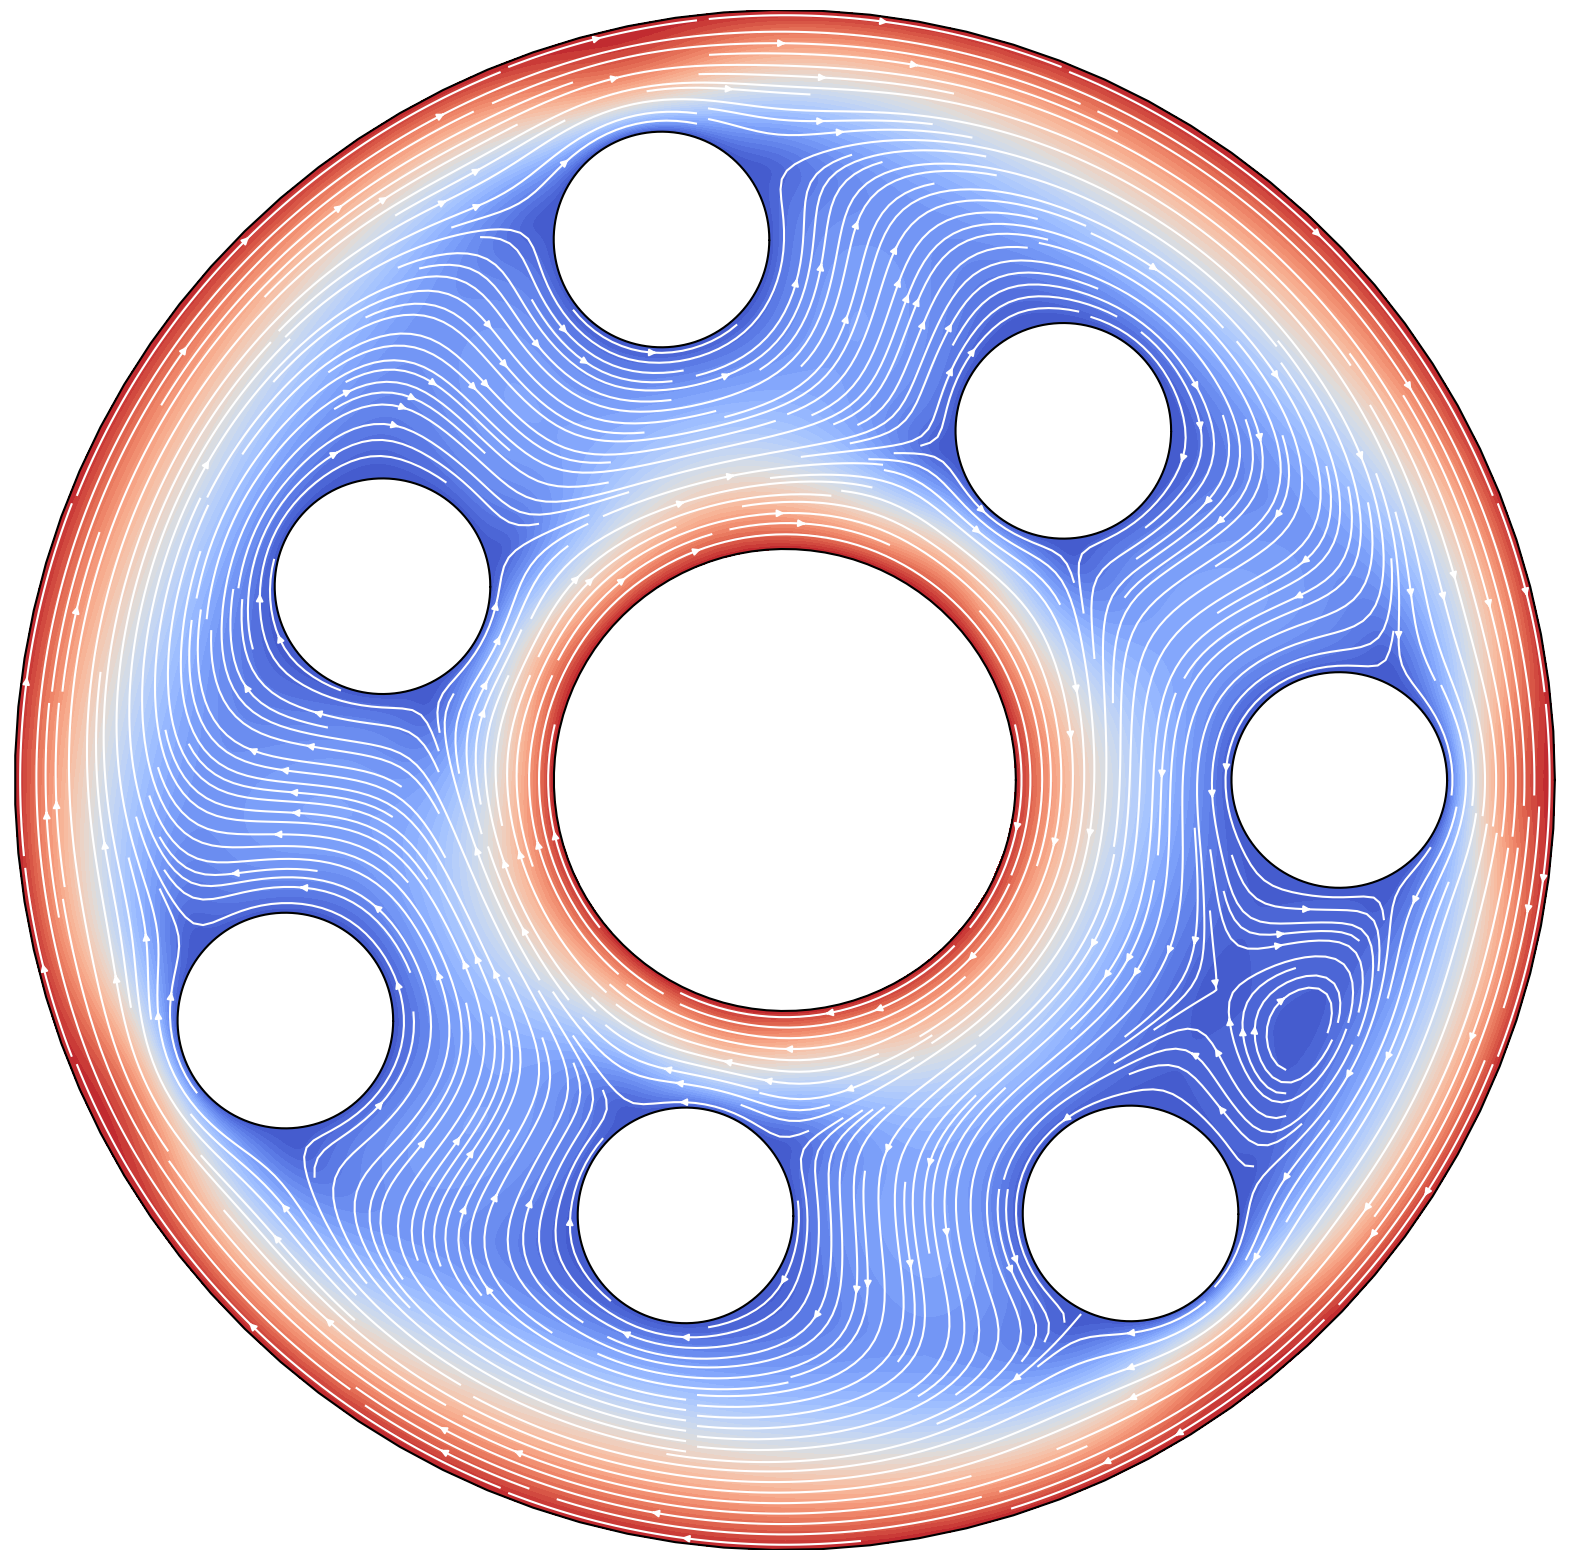

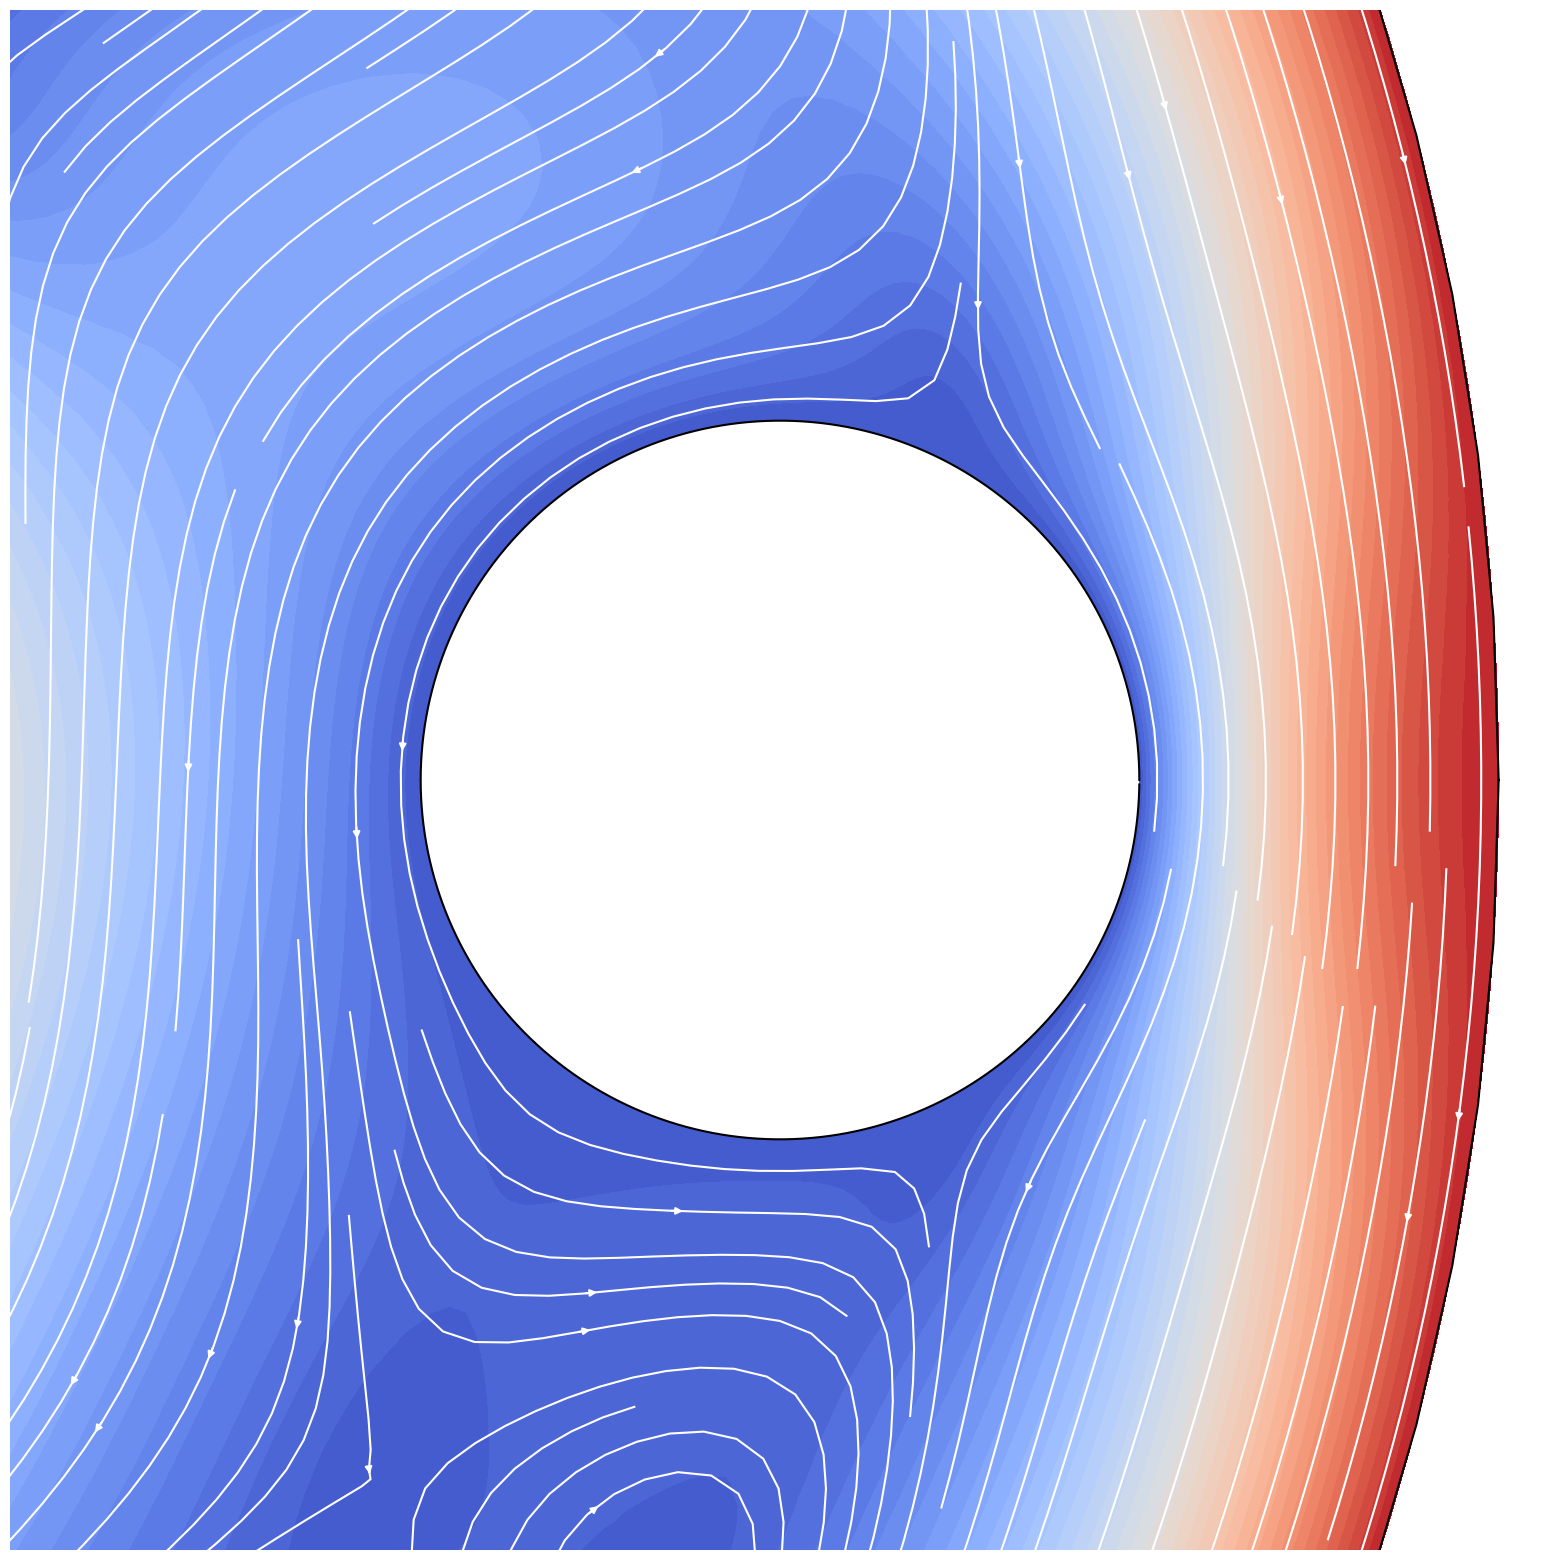

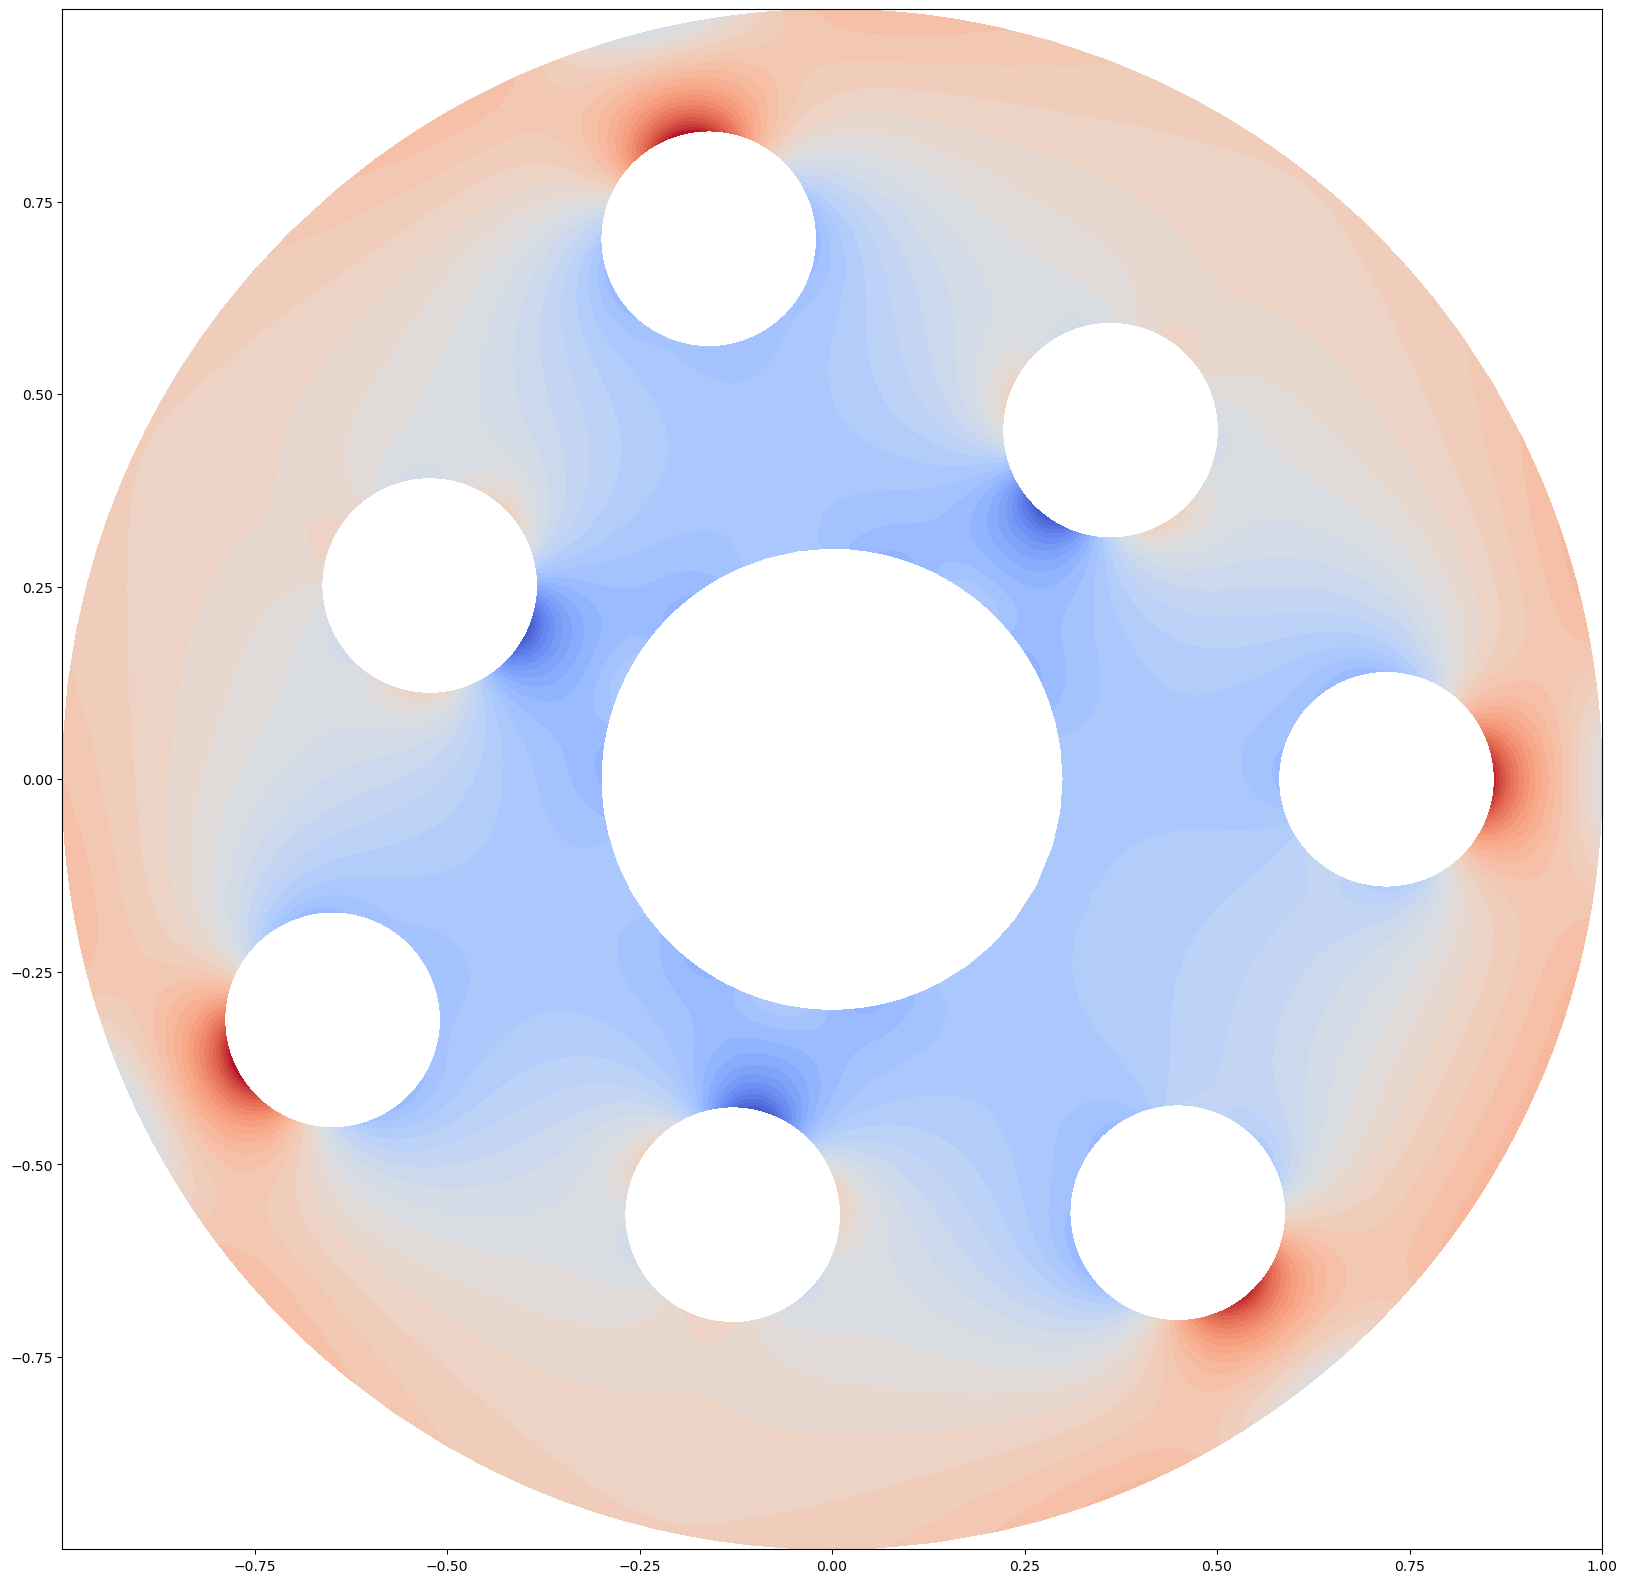

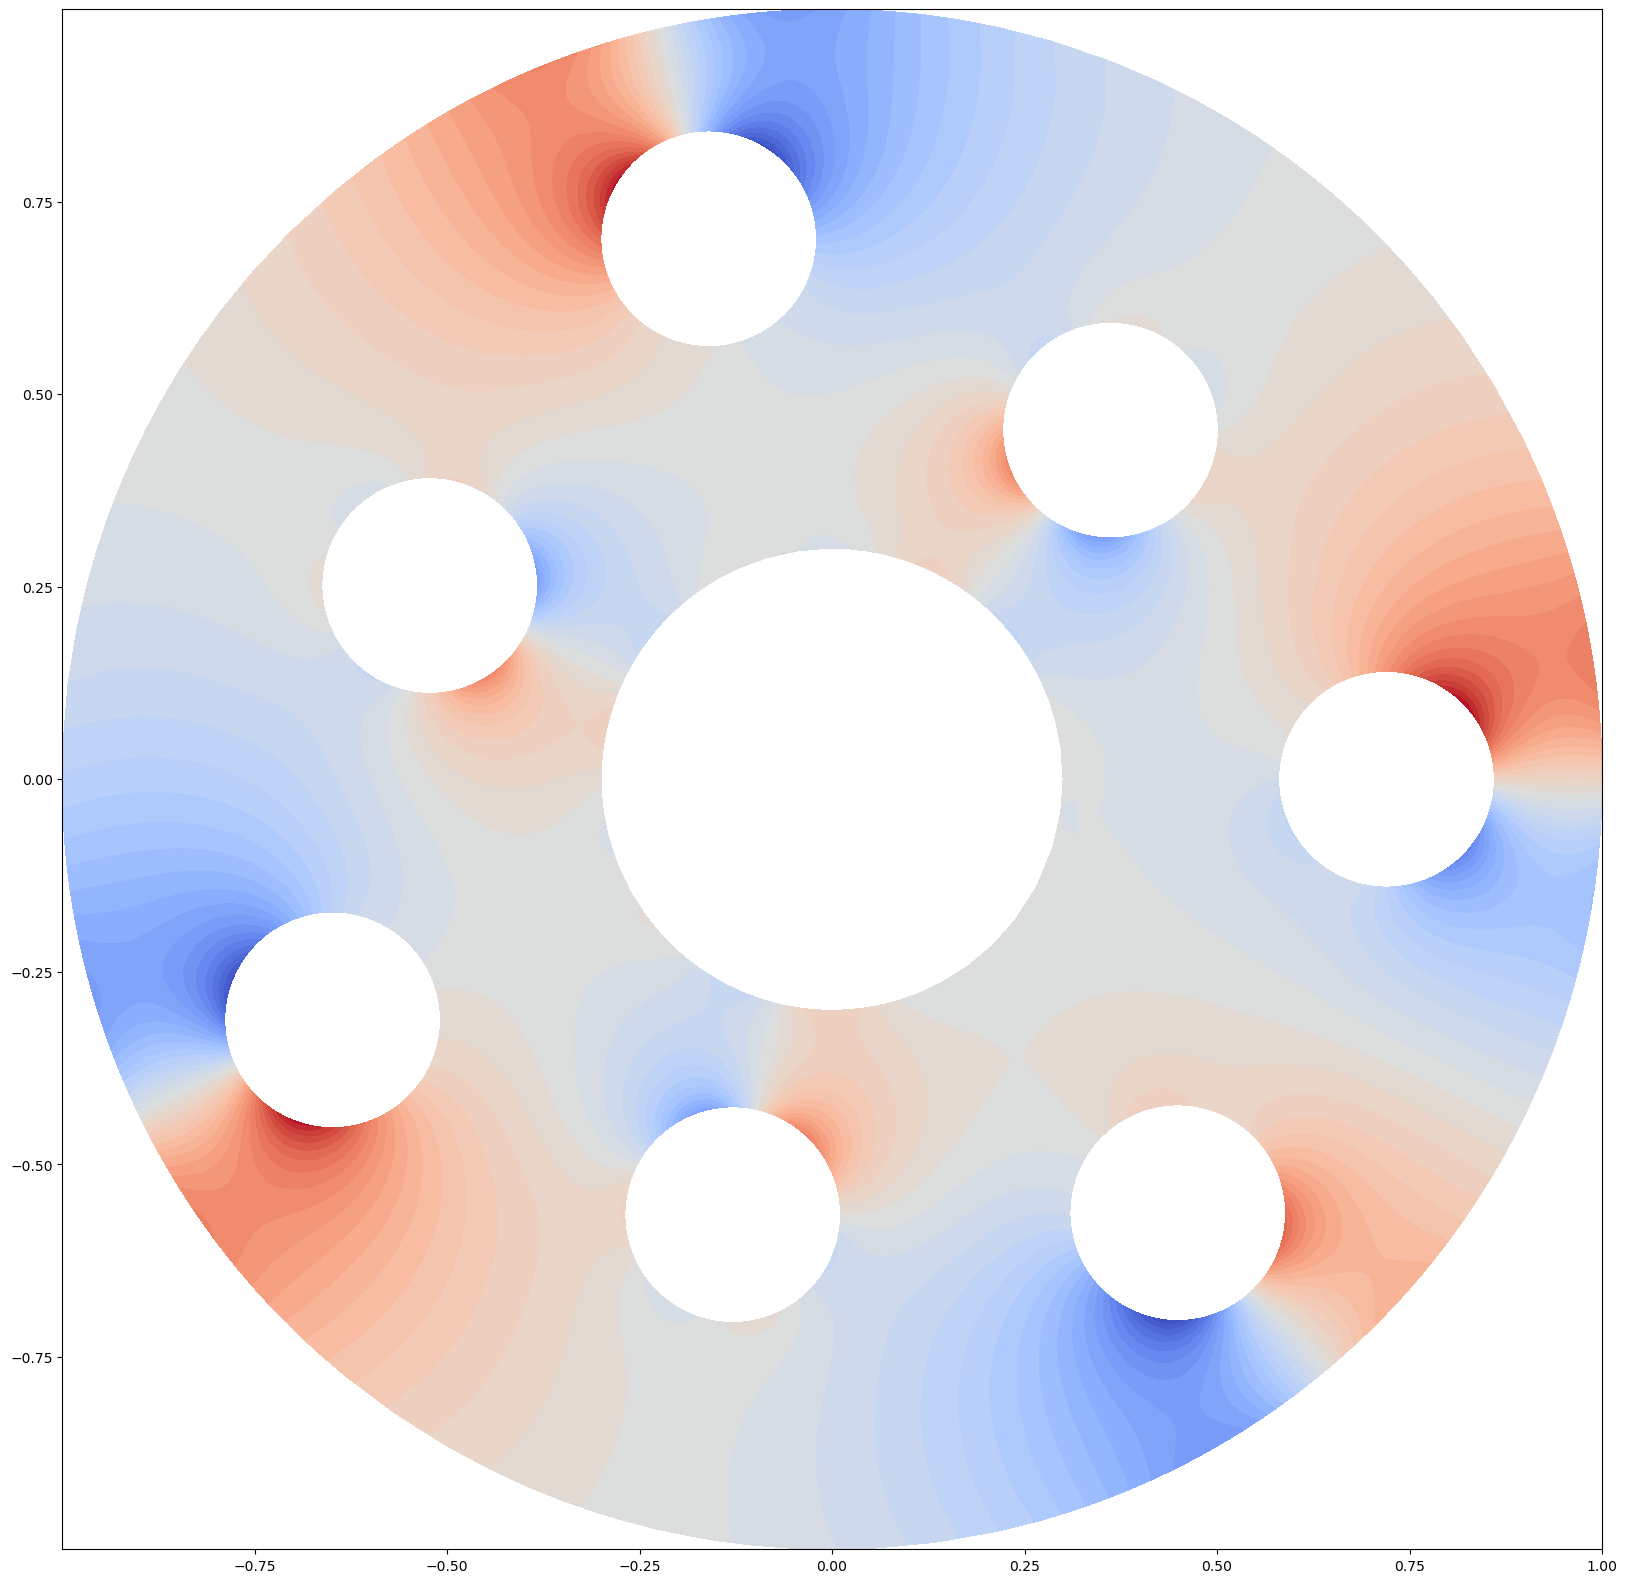

In [15]:
abs_u = (sol.u * sol.u + sol.v * sol.v) ** 0.5
w = sol.grad_u[1] - sol.grad_v[0]
#print(sol.u.vector()[:])

plt.figure(figsize=(20,20))
dl.plot(abs_u, cmap='coolwarm')#, vmin=0., vmax=1.)
sol.plot_stream(plt.gca(), dom=mesh, bbox=[[-1.,1.], [-1., 1.]], npts=300, color='white', density=5)
data.plot(plt.gca())
remove_axes(plt.gca())
plt.axis("equal")

plt.figure(figsize=(20,20))
dl.plot(abs_u, cmap='coolwarm')#, vmin=0., vmax=1.)
sol.plot_stream(plt.gca(), dom=mesh, bbox=[[-1.,1.], [-1., 1.]], npts=300, color='white', density=5)
data.plot(plt.gca())
remove_axes(plt.gca())
plt.ylim([data.x_blobs[0].y()-0.3, data.x_blobs[0].y()+0.3])
plt.xlim([data.x_blobs[0].x()-0.3, data.x_blobs[0].x()+0.3])

plt.figure(figsize=(20,20))
dl.plot(w, cmap='coolwarm')#, vmin=-10., vmax=10.)

plt.figure(figsize=(20,20))
dl.plot(sol.p, cmap='coolwarm')#, vmin=-20., vmax=20.)

In [16]:
xc, yc = data.x_blobs[0].x(), data.x_blobs[0].y()

t = np.linspace(0, 2*np.pi, 100)
gs = np.linspace(0, 1, 100)
x_list = [xc + (data.r_blobs*(1-g) + (data.R - xc)*0.9*g) * np.cos(t) for g in gs]
y_list = [yc + (data.r_blobs*(1-g) + (data.R - xc)*0.9*g) * np.sin(t) for g in gs]
u_list = [np.array([sol.u(x, y) for x, y in zip(xv, yv)]) for xv, yv in zip(x_list, y_list)]

save_data = {'t': t, 'g': gs, 'x': x_list, 'y': y_list, 'u': u_list}
np.savez(f'{simulation_dir}/naive_sim.npz', **save_data)